In [2]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import xarray
import rioxarray
import rasterio

### Read Nigeria shapefile

In [3]:
borders = gpd.read_file(Path('../assets/nigeria_borders.shp'))
borders

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,2,Nigeria,NGA,0,2,Sovereign country,Nigeria,NGA,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((7.30078 4.41816, 7.20391 4.387..."


In [6]:
borders.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

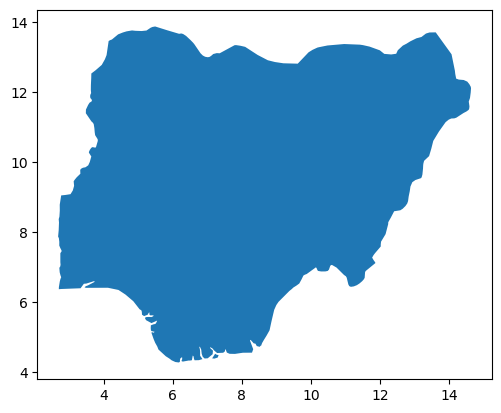

In [4]:
borders.plot()

In [7]:
shapes = shapely.geometry.mapping(borders.geometry[0])
shapes

{'type': 'MultiPolygon',
 'coordinates': [(((7.30078125, 4.418164062499997),
    (7.203906250000017, 4.387646484374997),
    (7.140429687500017, 4.3951171874999915),
    (7.227343750000017, 4.52734375),
    (7.271386718750023, 4.498925781249994),
    (7.327929687500017, 4.487207031249994),
    (7.30078125, 4.418164062499997)),),
  (((13.606347656250023, 13.70458984375),
    (13.763476562500017, 13.489550781250003),
    (13.932324218750011, 13.258496093749997),
    (14.06396484375, 13.078515624999994),
    (14.160058593750023, 12.61279296875),
    (14.170312500000023, 12.524072265624994),
    (14.177636718750023, 12.484082031249997),
    (14.184863281250017, 12.447216796874997),
    (14.197460937500011, 12.3837890625),
    (14.272851562500023, 12.356494140624989),
    (14.415429687500023, 12.344140624999994),
    (14.518945312500023, 12.298242187499994),
    (14.580957031250023, 12.222070312499994),
    (14.587011718750006, 12.209423828124997),
    (14.619726562500006, 12.15097656249999

### Read raster

In [8]:
preds_dir = Path("../data/predictions/nigeria-cropharvest-full-country-2020")
base_filename = 'combined'
tif_path = preds_dir / f'{base_filename}_binary_uint8_lzw.tif'

In [22]:
# Open and check size in RAM, plot
with rasterio.open(tif_path) as map:
    meta = map.meta
    compress = map.profile['compress']
    #data = map.read(1)
meta, compress

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 134346,
  'height': 109171,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 14.047584918475842)},
 'lzw')

### Clip

In [27]:
# read imagery file
with rasterio.open(tif_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, borders.geometry[0], crop=True, all_touched=True, nodata=meta['nodata'])
    out_meta = src.meta
    compress = src.profile['compress']

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu/lib/python3.7/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu/lib/python3.7/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [28]:
out_image

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [29]:
out_image.shape

(1, 106817, 132866)

In [30]:
out_transform

Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
       0.0, -8.983152841193113e-05, 13.872862595714636)

In [31]:
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 14.047584918475842)}

In [32]:
out_meta.update({'transform': out_transform, 'compress': compress})
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 13.872862595714636),
 'compress': 'lzw'}

In [35]:
data = np.squeeze(out_image)

In [36]:
clip_path = tif_path.parent / tif_path.name.replace('.tif', '_clipped.tif')

In [37]:
# Save clipped image
with rasterio.open(clip_path, "w", **out_meta) as dst:
    dst.write(data, 1) # new file is 14GB so it's not compressing for some reason

### Repeat for probability raster

In [40]:
prob_tif_path = Path(str(tif_path).replace('binary', 'prob'))
prob_tif_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/combined_prob_uint8_lzw.tif')

In [48]:
# read imagery file
with rasterio.open(prob_tif_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, borders.geometry[0], crop=True, all_touched=True, nodata=meta['nodata'])
    out_meta = src.meta
    compress = src.profile['compress']

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu/lib/python3.7/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu/lib/python3.7/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [49]:
out_meta.update({'transform': out_transform, 'compress': compress})
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 134346,
 'height': 109171,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
        0.0, -8.983152841193113e-05, 13.872862595714636),
 'compress': 'lzw'}

In [50]:
data = np.squeeze(out_image)

In [51]:
clip_path = prob_tif_path.parent / prob_tif_path.name.replace('.tif', '_clipped.tif')
clip_path

PosixPath('../data/predictions/nigeria-cropharvest-full-country-2020/combined_prob_uint8_lzw_clipped.tif')

In [52]:
# Save clipped image
with rasterio.open(clip_path, "w", **out_meta) as dst:
    dst.write(data, 1)